In [1]:
import sys
if 'google.colab' in sys.modules:
	!pip install --upgrade datasets
	from IPython.display import clear_output
	clear_output()

Set a device

In [2]:
import torch
seed = 42

if torch.accelerator.is_available():
	device = torch.accelerator.current_accelerator().type
	torch.set_default_device(device)
	def set_seed(seed=seed):
		torch.cuda.manual_seed_all(seed)
	set_seed()
else:
	device = 'cpu'
	def set_seed(seed=seed):
		torch.manual_seed(seed)
	set_seed()

device

'cuda'

Custom functions

In [3]:
import time
start_time = None

def start_timer():
	global start_time  # Use global keyword to modify the global start_time
	start_time = time.time()

def end_timer(tag='\t Elapsed time'):
	global start_time
	if start_time is None:
		print('Timer has not been started.')
		return
	end_time = time.time()
	elapsed_time = end_time - start_time
	print(f'{tag}: {elapsed_time:.2f} seconds')
	start_time = None

## Loading an embedding model

In [4]:
from sentence_transformers import SentenceTransformer

embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

@torch.inference_mode()  # Disable unnecessary computation (if not using gradients of this model)
def get_embedding(sentence):
	embedding = embed_model.encode(sentence, normalize_embeddings=True)
	return torch.tensor(embedding, device=device)

# Find embedding dimension
start_timer()
test_embedding = get_embedding('This is a test sentence')
end_timer()

embedding_dim = len(test_embedding)
embedding_dim

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

	 Elapsed time: 0.42 seconds


384

## Load a dataset

In [5]:
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader, Dataset

dataset = load_dataset('imdb')  # Load IMDB dataset
# # select 1000 samples for test
# dataset['partial_test'] = dataset['test'].shuffle(seed=seed).select(range(1000))
# temporarily use training data for testing
dataset['partial_test'] = dataset['train'].train_test_split(test_size=0.1, seed=seed)['test']
print(f'Dataset loaded: {len(dataset["train"])} training samples, {len(dataset["test"])} test samples, ')
print(f'            and {len(dataset["partial_test"])} partial-test samples')

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset loaded: 25000 training samples, 25000 test samples, 
            and 2500 partial-test samples


In [6]:
class IMDBDataset(Dataset):
	def __init__(self, data, embed_function, max_length=100):
		self.data = data
		self.embed_function = embed_function
		self.max_length = max_length

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		text = self.data[idx]['text']
		label = self.data[idx]['label']  # it is already either 0 or 1
		embedding = self.embed_function(text)
		return {
			'text': text,
			'embedding': embedding,
			'label': torch.tensor(label)
		}

batch_size = 128
generator = torch.Generator(device=device).manual_seed(seed)

train_data = IMDBDataset(dataset['train'], get_embedding)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=generator)

partial_test_data = IMDBDataset(dataset['partial_test'], get_embedding)
partial_test_loader = DataLoader(partial_test_data, batch_size=batch_size, shuffle=True, generator=generator)

test_data = IMDBDataset(dataset['test'], get_embedding)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, generator=generator)

## Create a model

<!-- include image Sentiment_analysis-network.png in markdown -->
<!-- ![Sentiment_analysis-network.png](https://github.com/prane-eth/job-notes/blob/main/1-Pytorch/practice/Sentiment_analysis-network.png?raw=1) -->
<img src="https://github.com/prane-eth/job-notes/blob/main/1-Pytorch/practice/Sentiment_analysis-network.png?raw=1" alt="Sentiment_analysis-network.png" height="700"/>

In [7]:
import torch.nn as nn
import torch.optim as optim

hidden_dim1 = 220
hidden_dim2 = 128
hidden_dim3 = 64
hidden_dim4 = 10
output_dim = 2  # to find positive/negative sentiments
dropout = 0.1

model = nn.Sequential(
	# Layer-1
	nn.Linear(embedding_dim, hidden_dim1),
	nn.LayerNorm(hidden_dim1),
	nn.ReLU(),  # 2 ReLU layers
	nn.Dropout(dropout),  # avoid over-fitting

	# Layer-2
	nn.Linear(hidden_dim1, hidden_dim2),
	nn.LayerNorm(hidden_dim2),
	nn.ReLU(),
	nn.Dropout(dropout),

	# Layer-3
	nn.Linear(hidden_dim2, hidden_dim3),
	nn.LayerNorm(hidden_dim3),
	nn.ELU(),  # 2 ELU layers
	nn.Dropout(dropout),

	# Layer-4
	nn.Linear(hidden_dim3, hidden_dim4),
	nn.LayerNorm(hidden_dim4),
	nn.ELU(),
	nn.Dropout(dropout),

	# Layer-5 - Output layer
	nn.Linear(hidden_dim4, output_dim),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
# Adam optimizer is preferred for DL models due to its adaptive learning rate and momentum capabilities.
# Weight decay (L2 regularization) penalizes large weights, further preventing overfitting and supporting generalization to achieve 90% accuracy.

num_epochs = 20  # Increase number of epochs for better performance
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
# total_steps = len(train_loader) * num_epochs

# from transformers import get_linear_schedule_with_warmup
# scheduler = get_linear_schedule_with_warmup(  # learning rate scheduler
# 	optimizer,
# 	num_warmup_steps=int(0.03 * total_steps),
# 	num_training_steps=total_steps,
# )

### Train the Model

In [8]:
from sklearn.metrics import accuracy_score

def train_epoch(model, dataloader, optimizer, criterion, device):
	set_seed()
	model.train()
	epoch_loss = 0
	all_preds = []
	all_labels = []

	for batch in dataloader:
		embedding = batch['embedding'].to(device)
		labels = batch['label'].to(device)

		# Forward pass
		optimizer.zero_grad()
		outputs = model(embedding)
		loss = criterion(outputs, labels)

		# Backward pass
		loss.backward()
		torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
		optimizer.step()

		# Record metrics
		epoch_loss += loss.item()
		preds = torch.argmax(outputs, dim=1).cpu().numpy()  # Can be on only a CPU
		all_preds.extend(preds)
		all_labels.extend(labels.cpu().numpy())

	# Calculate accuracy
	accuracy = accuracy_score(all_labels, all_preds)
	return epoch_loss / len(dataloader), accuracy

def evaluate(model, dataloader, criterion, device):
	set_seed()
	model.eval()  # set model to evaluation mode
	epoch_loss = 0
	all_preds = []
	all_labels = []

	with torch.no_grad():
		for batch in dataloader:
			embedding = batch['embedding'].to(device)
			labels = batch['label'].to(device)

			# Forward pass
			outputs = model(embedding)
			loss = criterion(outputs, labels)

			epoch_loss += loss.item()
			preds = torch.argmax(outputs, dim=1).cpu().numpy()
			all_preds.extend(preds)
			all_labels.extend(labels.cpu().numpy())

	accuracy = accuracy_score(all_labels, all_preds)
	return epoch_loss / len(dataloader), accuracy

Training...
Epoch 1/20:
  Train Accuracy: 0.7448
	 Elapsed time: 274.25 seconds
  Val Accuracy: 0.8120
	 Elapsed time: 27.02 seconds

Epoch 2/20:
  Train Accuracy: 0.8089
	 Elapsed time: 271.17 seconds
  Val Accuracy: 0.8284
	 Elapsed time: 28.31 seconds

Epoch 3/20:
  Train Accuracy: 0.8264
	 Elapsed time: 273.39 seconds
  Val Accuracy: 0.8216
	 Elapsed time: 27.61 seconds

Epoch 4/20:
  Train Accuracy: 0.8311
	 Elapsed time: 270.77 seconds
  Val Accuracy: 0.8432
	 Elapsed time: 26.73 seconds

Epoch 5/20:
  Train Accuracy: 0.8447
	 Elapsed time: 269.39 seconds
  Val Accuracy: 0.8584
	 Elapsed time: 27.31 seconds

Epoch 6/20:
  Train Accuracy: 0.8582
	 Elapsed time: 269.22 seconds
  Val Accuracy: 0.8900
	 Elapsed time: 26.67 seconds

Epoch 7/20:
  Train Accuracy: 0.8645
	 Elapsed time: 287.10 seconds
  Val Accuracy: 0.8996
	 Elapsed time: 26.61 seconds

Epoch 8/20:
  Train Accuracy: 0.8810
	 Elapsed time: 268.43 seconds
  Val Accuracy: 0.9100
	 Elapsed time: 27.29 seconds

Epoch 9/20:


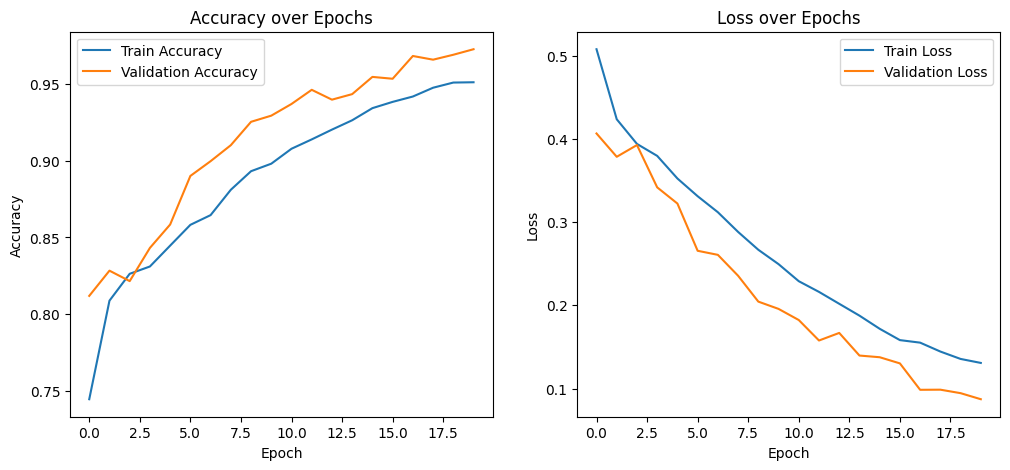

In [9]:
import matplotlib.pyplot as plt

best_accuracy = 0
best_model_state = None

train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

print('Training...')
for epoch in range(num_epochs):
	print(f'Epoch {epoch+1}/{num_epochs}:')

	# Train the model
	start_timer()
	train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
	print(f'    Train Accuracy: {train_acc:.4f}')
	train_accuracies.append(train_acc)
	train_losses.append(train_loss)
	end_timer()

	# Evaluate the model
	start_timer()
	val_loss, val_acc = evaluate(model, partial_test_loader, criterion, device)
	print(f'    Val Accuracy: {val_acc:.4f}')
	val_accuracies.append(val_acc)
	val_losses.append(val_loss)
	end_timer()
	print()

	# scheduler.step()  # Update learning rate
	if val_acc > best_accuracy:  # Save best model
		best_accuracy = val_acc
		best_model_state = model.state_dict().copy()

# Plot accuracy and loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

In [10]:
# Load best model and evaluation results
if best_model_state:
	model.load_state_dict(best_model_state)
	print(f'Loaded best model with the best validation accuracy: {best_accuracy:.4f}')

# Final Evaluation - on the full test set
print(f'Final evaluation...')
start_timer()
final_loss, final_accuracy = evaluate(model, test_loader, criterion, device)
end_timer()
print(f'Final Test Results:')
print(f'  Accuracy: {final_accuracy:.4f}')

Loaded best model with the best validation accuracy: 0.9724
Final evaluation...
	 Elapsed time: 269.92 seconds
Final Test Results:
  Accuracy: 0.7783


### Predict on custom text

In [11]:
# Test with some example reviews
test_reviews = [
	'This movie was fantastic! I loved it.',  # Positive
	'The acting was terrible and the plot made no sense.',  # Negative
	'A masterpiece of cinema that will be remembered for decades.',  # Positive
	'I wasted two hours of my life watching this garbage.',  # Negative
]

print('Testing with example reviews: \n')
model.eval()
for review in test_reviews:
	print(f'Review: {review}')
	embedding = get_embedding(review)

	# Add a batch dimension to the embedding
	embedding = embedding.unsqueeze(0)

	# Make prediction
	with torch.no_grad():
		outputs = model(embedding)
		prediction = torch.argmax(outputs, dim=1).item()

	sentiment = 'Positive' if prediction == 1 else 'Negative'
	print(f'Predicted sentiment: {sentiment}\n')

# torch.save(model.state_dict(), 'sentiment_classifier.pt')  # Save the model
# # To load the model
# model = nn.Sequential( .... )
# model.load_state_dict(torch.load('sentiment_classifier.pt'))

Testing with example reviews: 

Review: This movie was fantastic! I loved it.
Predicted sentiment: Positive

Review: The acting was terrible and the plot made no sense.
Predicted sentiment: Negative

Review: A masterpiece of cinema that will be remembered for decades.
Predicted sentiment: Positive

Review: I wasted two hours of my life watching this garbage.
Predicted sentiment: Negative

